# To predict Rice Leaf disease by using Convolutional Neural Network

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# **Set all the Constants**

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

# **Import data into tensorflow dataset object**

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "CNN",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 119 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 2 2 1 0 1 0 1 1 1 2 0 1 0 1 1 1 0 0 2 2 1 2 1 1 1 2 0 2 0 0]


# **Visualize some of the images from our dataset**

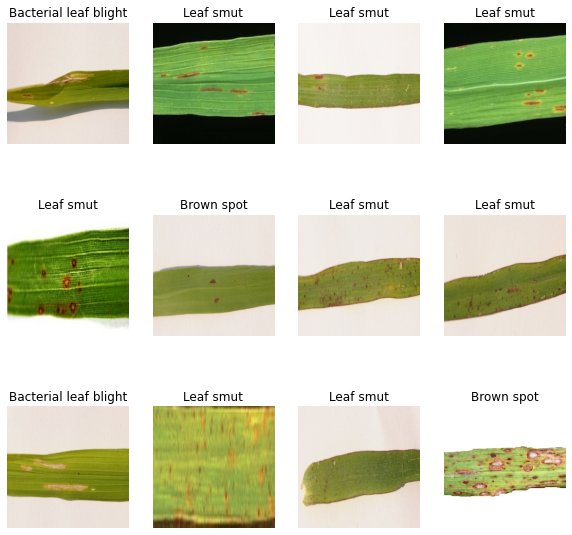

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# **Function to Split Dataset**
Dataset should be bifurcated into 3 subsets, namely:

1.Training: Dataset to be used while training

2.Validation: Dataset to be tested against while training

3.Test: Dataset to be tested against after we trained a model

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# **Cache, Shuffle, and Prefetch the Dataset**

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Building the Model**

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# **Data Augmentation**

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# **Applying Data Augmentation to Train Dataset**

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



# **Model Architecture**

# **Using CNN**

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# **Compiling the Model**
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
3/3 [==============================] - 5s 1s/step - loss: 1.1210 - accuracy: 0.4023
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 1.0963 - accuracy: 0.4253
Epoch 3/50
3/3 [==============================] - 4s 2s/step - loss: 1.0703 - accuracy: 0.4253
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 1.0154 - accuracy: 0.4713
Epoch 5/50
3/3 [==============================] - 4s 2s/step - loss: 0.9819 - accuracy: 0.5172
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 0.9657 - accuracy: 0.5632
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 0.9171 - accuracy: 0.5977
Epoch 8/50
3/3 [==============================] - 4s 1s/step - loss: 0.8841 - accuracy: 0.5287
Epoch 9/50
3/3 [==============================] - 4s 1s/step - loss: 0.8695 - accuracy: 0.6667
Epoch 10/50
3/3 [==============================] - 4s 1s/step - loss: 0.7827 - accuracy: 0.7011
Epoch 11/50
3/3 [==============================] 

In [17]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 1s 935ms/step - loss: 0.2095 - accuracy: 0.9375


In [18]:
scores = model.evaluate(train_ds)

3/3 [==============================] - 2s 479ms/step - loss: 0.2327 - accuracy: 0.9195


**we can see that the test accuracy is 93% ,but the train data is 91% so we can see that the model is overfitting** 

# **Since the model is overfitting so we use Dropout function**

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
3/3 [==============================] - 5s 1s/step - loss: 1.8208 - accuracy: 0.3678
Epoch 2/50
3/3 [==============================] - 5s 2s/step - loss: 1.2641 - accuracy: 0.3103
Epoch 3/50
3/3 [==============================] - 5s 1s/step - loss: 1.0976 - accuracy: 0.3448
Epoch 4/50
3/3 [==============================] - 5s 1s/step - loss: 1.0968 - accuracy: 0.3678
Epoch 5/50
3/3 [==============================] - 5s 2s/step - loss: 1.0925 - accuracy: 0.3678
Epoch 6/50
3/3 [==============================] - 5s 1s/step - loss: 1.0920 - accuracy: 0.3678
Epoch 7/50
3/3 [==============================] - 5s 2s/step - loss: 1.0866 - accuracy: 0.3678
Epoch 8/50
3/3 [==============================] - 5s 2s/step - loss: 1.0851 - accuracy: 0.3678
Epoch 9/50
3/3 [==============================] - 5s 1s/step - loss: 1.0787 - accuracy: 0.3678
Epoch 10/50
3/3 [==============================] - 5s 1s/step - loss: 1.0793 - accuracy: 0.3678
Epoch 11/50
3/3 [==============================] 

In [22]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 1s 510ms/step - loss: 0.6288 - accuracy: 0.7500


In [23]:
scores = model.evaluate(train_ds)

3/3 [==============================] - 2s 485ms/step - loss: 0.6034 - accuracy: 0.7931


**You can see above that we get 75% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [24]:
scores

[0.603356659412384, 0.7931034564971924]

 **Plotting the Accuracy and Loss Curves**

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 3}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [28]:
type(history.history['loss'])

list

In [29]:
len(history.history['loss'])

50

In [30]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.820813775062561,
 1.2641098499298096,
 1.097589373588562,
 1.0967607498168945,
 1.0924638509750366]

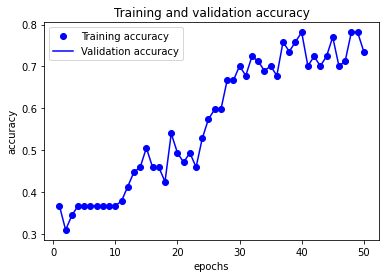

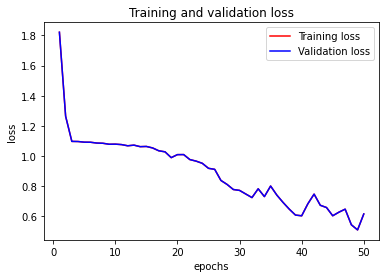

In [31]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["accuracy"]
loss = history.history["loss"]
val_loss = history.history["loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

 # **Run prediction on a sample image**

first image to predict
actual label: Brown spot
1/1 [==============================] - 0s 480ms/step
predicted label: Bacterial leaf blight


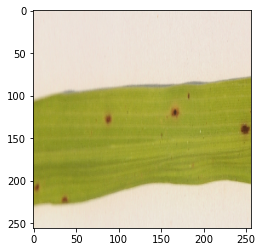

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# **Function for inference**

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 31ms/step


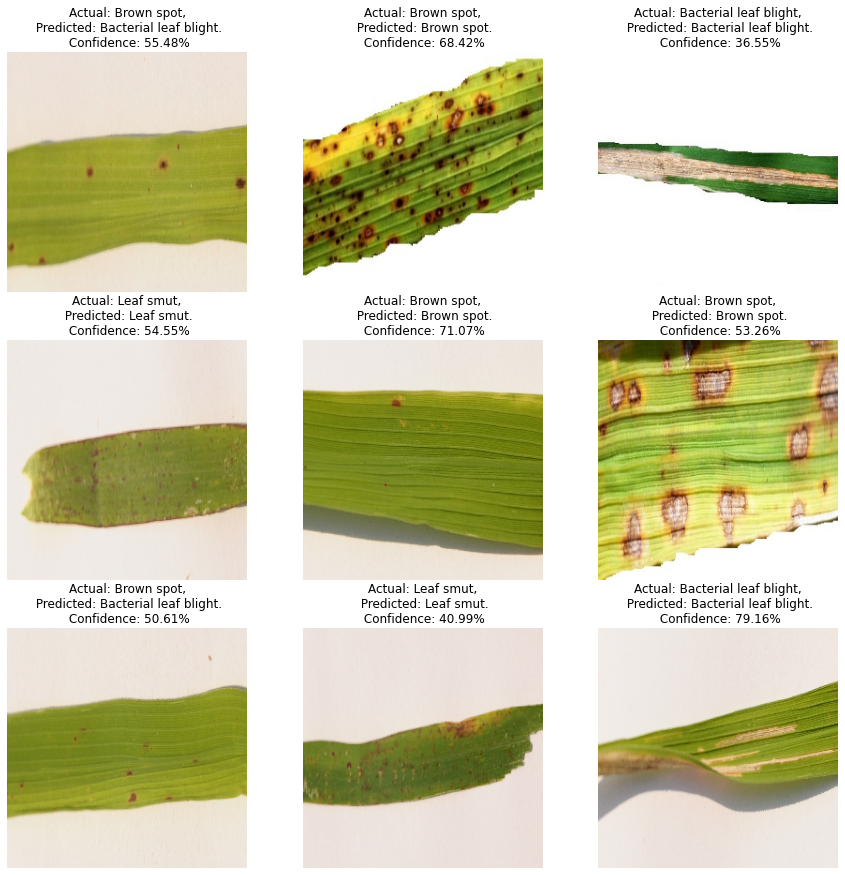

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")